In [19]:
from utils.util import *
from matplotlib import pyplot as plt
import torch.optim as optim
# Set seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
data = Loader(data_dir="data/home-credit-default-risk").load_csv(file_name="application_train.csv")

In [21]:
count_columns = data.columns

In [22]:
for i in count_columns:
    print(i)

SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APART

In [23]:
important_features = [
    "AMT_INCOME_TOTAL",  # Applicant's income level
    "AMT_CREDIT",  # Loan amount requested
    "AMT_ANNUITY",  # Monthly installment amount
    "AMT_GOODS_PRICE",  # Value of the house
    "DAYS_EMPLOYED",  # Employment history (longer employment = more stable)
    "NAME_INCOME_TYPE",  # Type of income (e.g., Working, Business, Pensioner)
    "NAME_EDUCATION_TYPE",  # Education level (higher education may correlate with stability)
    # "OCCUPATION_TYPE",  # Type of job (some jobs are riskier than others)
    "CNT_CHILDREN",  # Number of children (affects financial burden)
    "CNT_FAM_MEMBERS",  # Total family members (affects living expenses)
    "REGION_RATING_CLIENT",  # Risk rating of applicant's region
    "EXT_SOURCE_2", #"EXT_SOURCE_1", "EXT_SOURCE_3",  # External credit score sources
    "DAYS_BIRTH",  # Age of applicant (younger applicants might have less credit history)
    "REG_CITY_NOT_WORK_CITY",  # If applicant's work and home city differ (stability factor)
    "LIVE_REGION_NOT_WORK_REGION",  # If applicant lives far from work region
    "FLAG_EMP_PHONE",  # Verified employment phone number (adds credibility)
    # "AMT_REQ_CREDIT_BUREAU_YEAR"  # Number of credit inquiries in the past year (high = risky)
]

irrelevant_features = [
    "SK_ID_CURR",  # Just an ID, no predictive value
    "FLAG_MOBIL",  # Almost always 1 (not useful for prediction)
    "FLAG_CONT_MOBILE",  # Mobile phone continuity doesn't reflect creditworthiness
    "FLAG_PHONE",  # Having a phone number isn't a strong predictor
    "FLAG_EMAIL",  # Having an email doesn’t impact financial status
    "DAYS_REGISTRATION",  # Registration date is unrelated to loan approval
    "DAYS_ID_PUBLISH",  # Date of ID issue has no real impact
    "OWN_CAR_AGE",  # Age of the car doesn’t determine loan approval
    "WEEKDAY_APPR_PROCESS_START",  # Day of application is irrelevant
    "HOUR_APPR_PROCESS_START",  # Hour of application is not a strong factor
    "REG_REGION_NOT_LIVE_REGION",  # Registration vs. living region mismatch isn't key
    "REG_REGION_NOT_WORK_REGION",  # Registration vs. work region mismatch is minor
    "LIVE_CITY_NOT_WORK_CITY",  # Not a strong determinant for loan approval
    "FONDKAPREMONT_MODE",  # Home repair fund info isn't relevant
    "EMERGENCYSTATE_MODE",  # Emergency state info doesn’t impact approval
    "OBS_30_CNT_SOCIAL_CIRCLE",  # Social circle observations not useful
    "DEF_30_CNT_SOCIAL_CIRCLE",  # Defaults in social circle are weak predictors
    "OBS_60_CNT_SOCIAL_CIRCLE",  # Same as above, for 60 days
    "DEF_60_CNT_SOCIAL_CIRCLE",  # Same as above, for 60 days
    "DAYS_LAST_PHONE_CHANGE",  # Changing phone doesn't impact loan approval
    "FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_4",  
    "FLAG_DOCUMENT_5", "FLAG_DOCUMENT_6", "FLAG_DOCUMENT_7",  
    "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_9", "FLAG_DOCUMENT_10",  
    "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13",  
    "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16",  
    "FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18", "FLAG_DOCUMENT_19",  
    "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21",  # Document flags have little effect on approval
    "APARTMENTS_AVG", "BASEMENTAREA_AVG", "YEARS_BEGINEXPLUATATION_AVG",  
    "YEARS_BUILD_AVG", "COMMONAREA_AVG", "ELEVATORS_AVG", "ENTRANCES_AVG",  
    "FLOORSMAX_AVG", "FLOORSMIN_AVG", "LANDAREA_AVG", "LIVINGAPARTMENTS_AVG",  
    "LIVINGAREA_AVG", "NONLIVINGAPARTMENTS_AVG", "NONLIVINGAREA_AVG",  
    "APARTMENTS_MODE", "BASEMENTAREA_MODE", "YEARS_BEGINEXPLUATATION_MODE",  
    "YEARS_BUILD_MODE", "COMMONAREA_MODE", "ELEVATORS_MODE", "ENTRANCES_MODE",  
    "FLOORSMAX_MODE", "FLOORSMIN_MODE", "LANDAREA_MODE", "LIVINGAPARTMENTS_MODE",  
    "LIVINGAREA_MODE", "NONLIVINGAPARTMENTS_MODE", "NONLIVINGAREA_MODE",  
    "APARTMENTS_MEDI", "BASEMENTAREA_MEDI", "YEARS_BEGINEXPLUATATION_MEDI",  
    "YEARS_BUILD_MEDI", "COMMONAREA_MEDI", "ELEVATORS_MEDI", "ENTRANCES_MEDI",  
    "FLOORSMAX_MEDI", "FLOORSMIN_MEDI", "LANDAREA_MEDI", "LIVINGAPARTMENTS_MEDI",  
    "LIVINGAREA_MEDI", "NONLIVINGAPARTMENTS_MEDI", "NONLIVINGAREA_MEDI",  
    "TOTALAREA_MODE",# "HOUSETYPE_MODE", "TOTALAREA_MODE", "WALLSMATERIAL_MODE",  # Property features not always available
    "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY",  
    "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON",  
    "AMT_REQ_CREDIT_BUREAU_QRT"  # Frequency of credit bureau inquiries isn't a strong factor
]

unfairness_risk_features = [
    "CODE_GENDER",  # Gender bias (e.g., females may have different approval rates)
    "FLAG_OWN_CAR",  # Owning a car might not be a fair creditworthiness factor
    "FLAG_OWN_REALTY",  # Homeownership may favor wealthier applicants
    "NAME_FAMILY_STATUS",  # Family status might introduce bias (e.g., single vs. married)
    "NAME_HOUSING_TYPE",  # Housing type may reflect economic background
    "REGION_POPULATION_RELATIVE",  # Population density may be a proxy for economic status
    "ORGANIZATION_TYPE",  # Some job sectors might be unfairly penalized
    "DAYS_BIRTH",  # Age-based discrimination (older/younger applicants may be treated unfairly)
    "OCCUPATION_TYPE",  # Some jobs may be historically underpaid but still creditworthy
    "REGION_RATING_CLIENT_W_CITY",  # Regional bias based on location
    "WALLSMATERIAL_MODE",  # Type of house construction could introduce socioeconomic bias
    "HOUSETYPE_MODE"  # House type may unfairly impact approval chances
]

target = ["TARGET"]


In [24]:
# data = data.drop(columns=irrelevant_features) # drop unuseage column
# data = data[list(set(important_features + unfairness_risk_features + target))] # reorder columns
# Identify columns with more than 10,000 missing values

cols_to_drop = [col for col in data.columns if data[col].isnull().sum() > 10000] + ["SK_ID_CURR"]
# Drop those columns
data = data.drop(columns=cols_to_drop)
data = data[data["CODE_GENDER"] != "XNA"] # drop rows with unknown
data = data.dropna() # drop rows with missing values
data = data.drop_duplicates() # drop duplicates
data = data.reset_index(drop=True)

In [25]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()

# Encode categorical columns
categorical_columns = list(data.select_dtypes(include=['object']).columns)
for column in categorical_columns:
    data[column] = le.fit_transform(data[column])

    # Reindex rows
    data = data.reset_index(drop=True)

data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
datadrop = data.drop(columns=["CODE_GENDER"]) # drop column CODE_GENDER

In [27]:
datainv = data.copy()
datainv['CODE_GENDER'] = datainv['CODE_GENDER'].apply(lambda x: 1 - x) #invert columns CODE_GENDER

In [28]:
DatasetD = DataSet(data=datadrop, y_col="TARGET")
train_dataD, test_dataD = DatasetD.get_datasets()
train_data_DL, val_data_DL = DatasetD.get_dataloaders(batch_size=2**12)

In [29]:
DatasetL = DataSet(data=data, y_col="TARGET")
train_data, test_data = DatasetL.get_datasets()
train_data_L, val_data_L = DatasetL.get_dataloaders(batch_size=round(512))

In [30]:
DatasetInvL = DataSet(data=datainv, y_col="TARGET")
train_dataInv, test_dataInv = DatasetInvL.get_datasets()

In [31]:
model = NeuralNetwork(d = 128, input = 63, output = 2, drop=0.5).to(device)

# Define the loss function and optimizer
# class_counts = torch.bincount(torch.argmax(train_data.y,dim=1))  # Count samples per class
# class_weights = 1.0 / class_counts.float()  # Inverse class frequency
# class_weights = class_weights / class_weights.sum()  # Normalize
# criterion_T = nn.BCELoss(weight=class_weights.to(device),reduction='sum')
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=5.0e-2)
model.eval()

NeuralNetwork(
  (layer1): Linear(in_features=63, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=512, bias=True)
  (layer4): Linear(in_features=512, out_features=256, bias=True)
  (layer5): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (normalization1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (normalization0): BatchNorm1d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (normalization2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (normalization3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid): Sigmoid()
)

In [32]:
model.load_state_dict(torch.load("model/model_house4.pth"))

<All keys matched successfully>

In [41]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    all_loss = []
    avg_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_data_L):
        inputs, targets = inputs.to(0), targets.to(0)
    # for i, data in enumerate(train_data_DL):
    #     inputs, targets = data
    #     inputs, targets = inputs.to(device), targets.to(device)
        if inputs.size(0) == 1:
            continue
        # Zero the gradients
        optimizer.zero_grad()
    
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())
        # all_loss.append(criterion_T(outputs, targets.float()).item())
        all_loss.append(loss.item())
    
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    # optimizer.zero_grad()
    
    # # Forward pass
    # outputs = model(train_data.X)
    # loss = criterion(outputs, train_data.y.float())
    
    # # Backward pass and optimization
    # loss.backward()
    # optimizer.step()
    
    if (epoch+1) % 2 == 0:
        avg_loss = sum(all_loss) / len(all_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
        model.eval()
        with torch.no_grad():
            # Forward pass
            test_outputs = model(test_data.X)
    
            # Calculate the loss
            test_loss = criterion(test_outputs, test_data.y.float())
    
            # Calculate accuracy
            predicted = torch.argmax(test_outputs, 1)
            labels = torch.argmax(test_data.y, 1)
            accuracy = (predicted == labels).sum().item() / labels.size(0)
            accuracy_f = (predicted == labels)[DatasetL.X_test['CODE_GENDER'].values == 0].sum().item() / labels[DatasetL.X_test['CODE_GENDER'].values == 0].size(0)
            accuracy_m = (predicted == labels)[DatasetL.X_test['CODE_GENDER'].values == 1].sum().item() / labels[DatasetL.X_test['CODE_GENDER'].values == 1].size(0)
            accuracy_0 = (predicted[labels == 0] == labels[labels == 0]).sum().item() / labels[labels == 0].size(0)
            accuracy_1 = (predicted[labels == 1] == labels[labels == 1]).sum().item() / labels[labels == 1].size(0)
            print(f'Test Accuracy for class 0: {accuracy_0 * 100:.2f}%, Test Accuracy for class 1: {accuracy_1 * 100:.2f}%')

            print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy_m * 100:.2f}%, {accuracy_f * 100:.2f}%')
            # print(f'Test Loss_f: {test_loss.item():.4f}, Test Accuracy_f: {accuracy_f * 100:.2f}%, {accuracy_f * 100:.2f}%')
    
            print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Epoch [2/100], Loss: 0.2421
Test Accuracy for class 0: 80.89%, Test Accuracy for class 1: 38.85%
Test Loss: 0.5059, Test Accuracy: 70.63%, 81.03%
Test Loss: 0.5059, Test Accuracy: 77.45%
Epoch [4/100], Loss: 0.2404
Test Accuracy for class 0: 81.39%, Test Accuracy for class 1: 37.97%
Test Loss: 0.4829, Test Accuracy: 72.30%, 80.74%
Test Loss: 0.4829, Test Accuracy: 77.84%
Epoch [6/100], Loss: 0.2392
Test Accuracy for class 0: 75.96%, Test Accuracy for class 1: 45.65%
Test Loss: 0.5245, Test Accuracy: 65.82%, 77.50%
Test Loss: 0.5245, Test Accuracy: 73.48%
Epoch [8/100], Loss: 0.2374
Test Accuracy for class 0: 77.77%, Test Accuracy for class 1: 41.84%
Test Loss: 0.4981, Test Accuracy: 67.30%, 78.78%
Test Loss: 0.4981, Test Accuracy: 74.83%
Epoch [10/100], Loss: 0.2331
Test Accuracy for class 0: 81.54%, Test Accuracy for class 1: 38.63%
Test Loss: 0.4950, Test Accuracy: 69.79%, 82.35%
Test Loss: 0.4950, Test Accuracy: 78.03%
Epoch [12/100], Loss: 0.2319
Test Accuracy for class 0: 84.09%, 

In [ ]:
# torch.save(model.state_dict(), 'model/model_house5.pth')

In [33]:
# Evaluation loop
model.eval()
with torch.no_grad():
    # Forward pass
    test_outputs = model(test_data.X)

    # Calculate the loss
    test_loss = criterion(test_outputs, test_data.y.float())
    
    # Calculate accuracy
    predicted = torch.argmax(test_outputs, 1)
    labels = torch.argmax(test_data.y, 1)
    accuracy = (predicted == labels).sum().item() / labels.size(0)
    accuracy_f = (predicted == labels)[DatasetL.X_test['CODE_GENDER'].values == 0].sum().item() / labels[DatasetL.X_test['CODE_GENDER'].values == 0].size(0)
    accuracy_m = (predicted == labels)[DatasetL.X_test['CODE_GENDER'].values == 1].sum().item() / labels[DatasetL.X_test['CODE_GENDER'].values == 1].size(0)
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy_m * 100:.2f}%, {accuracy_f * 100:.2f}%')
    # print(f'Test Loss_f: {test_loss.item():.4f}, Test Accuracy_f: {accuracy_f * 100:.2f}%, {accuracy_f * 100:.2f}%')
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.5781, Test Accuracy: 57.51%, 61.07%
Test Loss: 0.5781, Test Accuracy: 59.85%


In [34]:
sum(predicted == 1)

tensor(25675, device='cuda:0')

In [35]:
men_0 = predicted[DatasetL.X_test['CODE_GENDER'].values == 0]
women_0 = predicted[DatasetL.X_test['CODE_GENDER'].values == 1]

In [36]:
sum(men_0==1)

tensor(16081, device='cuda:0')

In [37]:
sum((women_0==1))

tensor(9594, device='cuda:0')

In [38]:
len(men_0[men_0 == 0])/len(men_0[men_0 == 1])

1.4849200920340775

In [39]:
len(women_0[women_0 == 0])/len(women_0[women_0 == 1])

1.1832395247029392

In [40]:
# Evaluation loop
model.eval()
with torch.no_grad():
    # Forward pass
    test_outputs = model(test_dataInv.X)

    # Calculate the loss
    test_loss = criterion(test_outputs, test_dataInv.y.float())
    
    # Calculate accuracy
    predicted = torch.argmax(test_outputs, 1)
    labels = torch.argmax(test_dataInv.y, 1)
    accuracy = (predicted == labels).sum().item() / labels.size(0)
    accuracy_f = (predicted == labels)[DatasetInvL.X_test['CODE_GENDER'].values == 0].sum().item() / labels[DatasetInvL.X_test['CODE_GENDER'].values == 0].size(0)
    accuracy_m = (predicted == labels)[DatasetInvL.X_test['CODE_GENDER'].values == 1].sum().item() / labels[DatasetInvL.X_test['CODE_GENDER'].values == 1].size(0)
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy_m * 100:.2f}%, {accuracy_f * 100:.2f}%')
    # print(f'Test Loss_f: {test_loss.item():.4f}, Test Accuracy_f: {accuracy_f * 100:.2f}%, {accuracy_f * 100:.2f}%')
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.6104, Test Accuracy: 51.01%, 64.48%
Test Loss: 0.6104, Test Accuracy: 55.64%


In [41]:
men_1 = predicted[DatasetInvL.X_test['CODE_GENDER'].values == 0]
women_1 = predicted[DatasetInvL.X_test['CODE_GENDER'].values == 1]

In [42]:
len(men_1[men_1 == 0])/len(men_1[men_1 == 1])

1.7192003115669219

In [43]:
len(women_1[women_1 == 0])/len(women_1[women_1 == 1])

0.9321148825065274

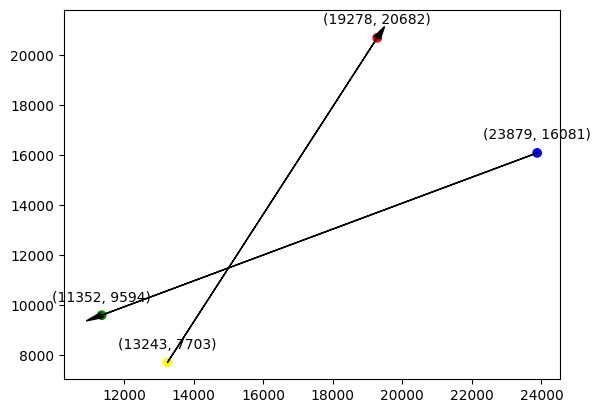

In [44]:
x = [len(men_0[men_0 == 0]), len(women_0[women_0 == 0]), len(men_1[men_1 == 0]), len(women_1[women_1 == 0])]
y = [len(men_0[men_0 == 1]), len(women_0[women_0 == 1]), len(men_1[men_1 == 1]), len(women_1[women_1 == 1])]
plt.figure(0)
plt.scatter(x, y,c=['blue', 'green', 'yellow', 'red'])
# plt.plot(x[:2], y[:2], 'k-', lw=2)
plt.arrow(x[0], y[0], x[1] - x[0], y[1] - y[0], head_width=200, head_length=500, fc='k', ec='k')
plt.arrow(x[2], y[2], x[3] - x[2], y[3] - y[2], head_width=200, head_length=500, fc='k', ec='k')
for i in range(len(x)):
    plt.annotate(f'({x[i]}, {y[i]})', (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.savefig("outputs/output_with_CODE_GENDER_unfairness1.png")
# plt.plot(x[2:], y[2:], 'k-', lw=2)

In [ ]:
###Drop gender columns

In [54]:
model = NeuralNetwork(d = 4, input = 22, output = 2).to(device)

# Define the loss function and optimizer
class_counts = torch.bincount(torch.argmax(train_dataD.y,dim=1))  # Count samples per class
class_weights = 1.0 / class_counts.float()  # Inverse class frequency
# class_weights = class_weights / class_weights.sum()  # Normalize
criterion_T = nn.BCELoss(weight=class_weights.to(device),reduction='sum')
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=2.5e-5)
model.eval()

NeuralNetwork(
  (layer1): Linear(in_features=22, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
  (normalization): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid): Sigmoid()
)

In [ ]:
model.load_state_dict(torch.load("model/model_house4D.pth"))

<All keys matched successfully>

In [55]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    # for batch_idx, (inputs, targets) in enumerate(train_loader):
    #    inputs, targets = inputs.to(0), targets.to(0)
    all_loss = []
    avg_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_data_L):
        inputs, targets = inputs.to(0), targets.to(0)
    # for i, data in enumerate(train_data_L):
    #     inputs, targets = data
    #     inputs, targets = inputs.to(device), targets.to(device)
        if inputs.size(0) == 1:
            continue
        # Zero the gradients
        optimizer.zero_grad()
    
        # Forward pass
        outputs = model(inputs[:, [i for i in range(inputs.shape[1]) if i != 4]])
        loss = criterion(outputs, targets.float())
        # all_loss.append(criterion_T(outputs, targets.float()).item())
        all_loss.append(loss.item())
    
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    # optimizer.zero_grad()
    
    # # Forward pass
    # outputs = model(train_data.X[:, [i for i in range(train_data.X.shape[1]) if i != 1]])
    # loss = criterion(outputs, train_data.y.float())
    
    # # Backward pass and optimization
    # loss.backward()
    # optimizer.step()
    
    if (epoch+1) % 2 == 0:
        avg_loss = sum(all_loss) / len(all_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
        model.eval()
        with torch.no_grad():
            # Forward pass
            test_outputs = model(test_data.X[:, [i for i in range(test_data.X.shape[1]) if i != 1]])
    
            # Calculate the loss
            test_loss = criterion(test_outputs, test_data.y.float())
    
            # Calculate accuracy
            predicted = torch.argmax(test_outputs, 1)
            labels = torch.argmax(test_data.y, 1)
            accuracy = (predicted == labels).sum().item() / labels.size(0)
            accuracy_f = (predicted == labels)[DatasetL.X_test['CODE_GENDER'].values == 0].sum().item() / labels[DatasetL.X_test['CODE_GENDER'].values == 0].size(0)
            accuracy_m = (predicted == labels)[DatasetL.X_test['CODE_GENDER'].values == 1].sum().item() / labels[DatasetL.X_test['CODE_GENDER'].values == 1].size(0)

            print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy_m * 100:.2f}%, {accuracy_f * 100:.2f}%')
            # print(f'Test Loss_f: {test_loss.item():.4f}, Test Accuracy_f: {accuracy_f * 100:.2f}%, {accuracy_f * 100:.2f}%')
    
            print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Epoch [2/100], Loss: 0.7126
Test Loss: 0.7331, Test Accuracy: 10.07%, 6.96%
Test Loss: 0.7331, Test Accuracy: 8.02%
Epoch [4/100], Loss: 0.7117
Test Loss: 0.7306, Test Accuracy: 10.07%, 6.96%
Test Loss: 0.7306, Test Accuracy: 8.02%
Epoch [6/100], Loss: 0.7108
Test Loss: 0.7279, Test Accuracy: 10.07%, 6.96%
Test Loss: 0.7279, Test Accuracy: 8.02%
Epoch [8/100], Loss: 0.7100
Test Loss: 0.7257, Test Accuracy: 10.07%, 6.96%
Test Loss: 0.7257, Test Accuracy: 8.02%
Epoch [10/100], Loss: 0.7091
Test Loss: 0.7236, Test Accuracy: 10.07%, 6.96%
Test Loss: 0.7236, Test Accuracy: 8.02%
Epoch [12/100], Loss: 0.7081
Test Loss: 0.7213, Test Accuracy: 10.07%, 6.96%
Test Loss: 0.7213, Test Accuracy: 8.02%
Epoch [14/100], Loss: 0.7073
Test Loss: 0.7185, Test Accuracy: 10.07%, 6.96%
Test Loss: 0.7185, Test Accuracy: 8.02%
Epoch [16/100], Loss: 0.7065
Test Loss: 0.7174, Test Accuracy: 10.53%, 8.19%
Test Loss: 0.7174, Test Accuracy: 8.99%
Epoch [18/100], Loss: 0.7057
Test Loss: 0.7158, Test Accuracy: 13.30

In [ ]:
# torch.save(model.state_dict(), 'model/model_house5D.pth')

In [57]:
# Evaluation loop
model.eval()
with torch.no_grad():
    # Forward pass
    test_outputs = model(test_data.X[:, [i for i in range(test_data.X.shape[1]) if i != 1]])

    # Calculate the loss
    test_loss = criterion(test_outputs, test_data.y.float())
    
    # Calculate accuracy
    predicted = torch.argmax(test_outputs, 1)
    labels = torch.argmax(test_data.y, 1)
    accuracy = (predicted == labels).sum().item() / labels.size(0)
    accuracy_f = (predicted == labels)[DatasetL.X_test['CODE_GENDER'].values == 0].sum().item() / labels[DatasetL.X_test['CODE_GENDER'].values == 0].size(0)
    accuracy_m = (predicted == labels)[DatasetL.X_test['CODE_GENDER'].values == 1].sum().item() / labels[DatasetL.X_test['CODE_GENDER'].values == 1].size(0)
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy_m * 100:.2f}%, {accuracy_f * 100:.2f}%')
    # print(f'Test Loss_f: {test_loss.item():.4f}, Test Accuracy_f: {accuracy_f * 100:.2f}%, {accuracy_f * 100:.2f}%')
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.6939, Test Accuracy: 42.01%, 47.52%
Test Loss: 0.6939, Test Accuracy: 45.63%


In [58]:
men_0 = predicted[DatasetL.X_test['CODE_GENDER'].values == 0]
women_0 = predicted[DatasetL.X_test['CODE_GENDER'].values == 1]

In [59]:
len(men_0[men_0 == 0])/len(men_0[men_0 == 1])

0.8239366515837104

In [60]:
len(women_0[women_0 == 0])/len(women_0[women_0 == 1])

0.6027930402930403

In [61]:
# Evaluation loop
model.eval()
with torch.no_grad():
    # Forward pass
    test_outputs = model(test_dataInv.X[:, [i for i in range(test_data.X.shape[1]) if i != 1]])

    # Calculate the loss
    test_loss = criterion(test_outputs, test_dataInv.y.float())
    
    # Calculate accuracy
    predicted = torch.argmax(test_outputs, 1)
    labels = torch.argmax(test_dataInv.y, 1)
    accuracy = (predicted == labels).sum().item() / labels.size(0)
    accuracy_f = (predicted == labels)[DatasetInvL.X_test['CODE_GENDER'].values == 0].sum().item() / labels[DatasetInvL.X_test['CODE_GENDER'].values == 0].size(0)
    accuracy_m = (predicted == labels)[DatasetInvL.X_test['CODE_GENDER'].values == 1].sum().item() / labels[DatasetInvL.X_test['CODE_GENDER'].values == 1].size(0)
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy_m * 100:.2f}%, {accuracy_f * 100:.2f}%')
    # print(f'Test Loss_f: {test_loss.item():.4f}, Test Accuracy_f: {accuracy_f * 100:.2f}%, {accuracy_f * 100:.2f}%')
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.6939, Test Accuracy: 47.52%, 42.01%
Test Loss: 0.6939, Test Accuracy: 45.63%


In [62]:
men_1 = predicted[DatasetInvL.X_test['CODE_GENDER'].values == 0]
women_1 = predicted[DatasetInvL.X_test['CODE_GENDER'].values == 1]

In [63]:
len(men_1[men_1 == 0])/len(men_1[men_1 == 1])

0.6027930402930403

In [64]:
len(women_1[women_1 == 0])/len(women_1[women_1 == 1])

0.8239366515837104

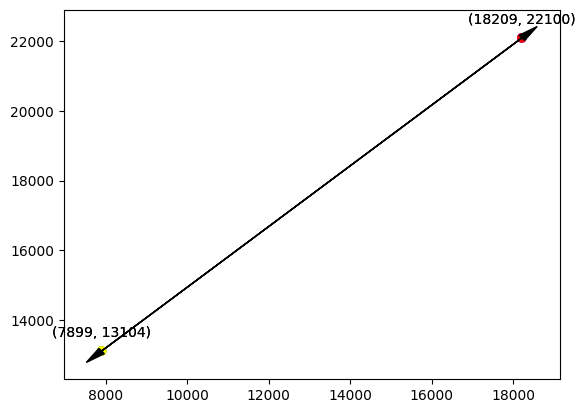

In [66]:
x = [len(men_0[men_0 == 0]), len(women_0[women_0 == 0]), len(men_1[men_1 == 0]), len(women_1[women_1 == 0])]
y = [len(men_0[men_0 == 1]), len(women_0[women_0 == 1]), len(men_1[men_1 == 1]), len(women_1[women_1 == 1])]
plt.figure(0)
plt.scatter(x, y,c=['blue', 'green', 'yellow', 'red'])
# plt.plot(x[:2], y[:2], 'k-', lw=2)
plt.arrow(x[0], y[0], x[1] - x[0], y[1] - y[0], head_width=200, head_length=500, fc='k', ec='k')
plt.arrow(x[2], y[2], x[3] - x[2], y[3] - y[2], head_width=200, head_length=500, fc='k', ec='k')
for i in range(len(x)):
    plt.annotate(f'({x[i]}, {y[i]})', (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.savefig("outputs/output_drop_gender_fairness1.png")
# plt.plot(x[2:], y[2:], 'k-', lw=2)